# Benford for 3D MRI - Model training with cross validation - Plot Figures with 2 metrics as input

This script trains several machine learning regression models to estimate the level of Rician noise from the divergences of the observed probability distributions of the first and second digits of the transformed versions of noisy 3D magnetic resonance images (MRIs) with respect to the theoretical Benford probability distributions of those digits.

We focus on the distributions of the first digits because the distributions of the second digits do not seem to contain much useful information.

We have tried all sets of input features for the regression models with two input features. 

We apply 10-fold cross validation. Samples from the same image are strongly correlated so they cannot be used in the training and validation sets.

Finally figures are plotted.

In [2]:
%reset

In [3]:
# Import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os 
from glob import glob 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

In [4]:
# Define the dataset to use, choosing one of the directories: 20OASIS_SynapseWeb_brain, OASIS-TRT-20_volumes, 12HLN, NKI-TRT-20_volumes, NKI-RS-22_volumes, MMRR-21_volumes
repository = '12HLN' # MUST TO DEFINE: #20OASIS_SynapseWeb_brain #OASIS-TRT-20_volumes #12HLN #NKI-TRT-20_volumes #NKI-RS-22_volumes #MMRR-21_volumes
typeImage = 't1weighted.nii.gz' #'t1weighted_brain.nii.gz' #'t1weighted.nii.gz'
inputDir = ('../input') 
outputDir = ('../output')

# Path with input images
dataMRI = os.path.join(inputDir, repository)
pathMRI = sorted(glob(dataMRI + '/**/' + typeImage, recursive=True))
SIZE = len(pathMRI)

# Training dataset path
str_path = os.path.join(outputDir + '/input/' + repository + '_head.pkl') 
dataset_path = str_path.replace("volumes", "head")

# Result folder path
str_path = os.path.join(outputDir + '/Figures_and_tables/' + repository)
result_path = str_path.replace("volumes", "head")

# Experiment parameters
NumNoiseLevels=20
NumNoiselessImages=SIZE # SIZE is the number of images in the repository: HLN=12; MMRR=21; NKI-RS=22; NKI-TRT=20; OASIS-TRT=20
MaxNoiseLevel=0.4
TestedTransforms=["FFT","DCT","DST"]
TestedPerformanceMeasures=["MSE","MAE","R2"]
TestedRegressors=["Linear","Poly","RandomForest","SVR","KernelRegression"]
NumSplits=10

In [8]:
# Load the training data file
with open(dataset_path,'rb') as MyFile: 
  [NoiseLevels,Divergences]=pickle.load(MyFile)

In [9]:
# Plot the best variables set and model (choose by first row in excel file) -

def plot_3D(xValidation, yValidation, noiseValidationPredicted, noiseValidationGT, xTraining, yTraining, noiseTrainingGT, xlabel, ylabel):
       
       fig, ax = plt.subplots(figsize=(10, 5))
       ax = plt.gca()
       
       sc1 = plt.scatter(xTraining, yTraining,
              marker="o", 
              cmap='Blues',
              linewidths=1, alpha=.7,
              edgecolor='k',
              s = 30,
              c=noiseTrainingGT, 
              vmin=0.00, vmax=0.50)
       sc2 = plt.scatter(xValidation, yValidation,
              marker="^",
              cmap='Reds',
              linewidths=1, alpha=.7,
              edgecolor='k',
              s = 200,
              c=noiseValidationPredicted, 
              vmin=0.00, vmax=0.50)
       sc3 = plt.scatter(xValidation, yValidation,
              marker="s", 
              cmap='Greens',
              linewidths=1, alpha=.7,
              edgecolor='k',
              s = 50,
              c=noiseValidationGT, 
              vmin=0.00, vmax=0.50)
       
       plt.xlabel('Mi', fontsize=10)#(str(xlabel))  # MUST TO DEFINE: write the value of the metric with a number.
       plt.ylabel('Mi', fontsize=10)#(str(ylabel))  # MUST TO DEFINE: write the value of the metric with a number.
       plt.title('')
       plt.tick_params(axis='both', labelsize=10)
       
       divider = make_axes_locatable(ax)
       cax1 = divider.append_axes("right", size="5%", pad=0.20)
       cax2 = divider.append_axes("right", size="5%", pad=0.75)
       cax3 = divider.append_axes("right", size="5%", pad=0.80)

       cabar1 = plt.colorbar(sc1, cax=cax1)
       cabar1.set_label('Training data, GT noise')
       cabar2 = plt.colorbar(sc2,  cax=cax2)
       cabar2.set_label('Validation data, predicted noise')
       cabar3 = plt.colorbar(sc3,  cax=cax3)
       cabar3.set_label('Validation data, GT noise')
       
       


       plot_path = os.path.join(result_path + '/FigureToPaper_%s.pdf' % (str(xlabel)+'_'+str(ylabel)))
       plt.savefig(plot_path, format="pdf", bbox_inches="tight")
       
       plt.show()

Fold 0:
  Train: index=[ 0  1  4  5  6  7  8  9 10 11]
  Test:  index=[2 3]
0
[0, 9]
23


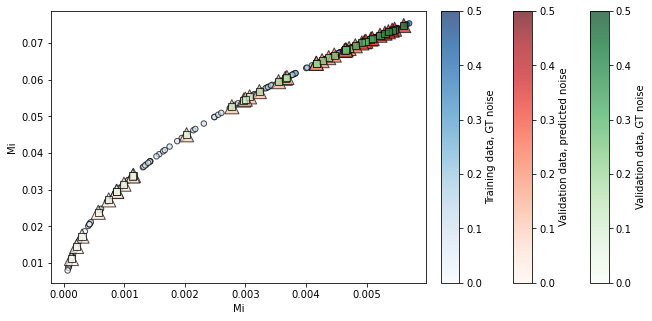

Fold 1:
  Train: index=[ 0  1  2  3  5  6  7  8  9 11]
  Test:  index=[ 4 10]
0
[0, 9]
23


KeyboardInterrupt: 

In [10]:
import os

# Import machine learning regression models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.metrics import r2_score

# Import cross validation
from sklearn.model_selection import KFold

# Import linear algebra error
from numpy.linalg import LinAlgError

# Define the input features that will be considered. Each input feature is defined
# by a tuple that indicates the transform, the probability distribution divergence
# measure, and the digit (first or second)
InputFeatures=[("FFT","BD","First"),("DCT","BD","First"),("DST","BD","First"),
               ("FFT","KL","First"),("DCT","KL","First"),("DST","KL","First"),
               ("FFT","TV","First"),("DCT","TV","First"),("DST","TV","First"),
               ("FFT","H","First"),("DCT","H","First"),("DST","H","First"),
               ("FFT","JS","First"),("DCT","JS","First"),("DST","JS","First"),
               ("FFT","BD","Second"),("DCT","BD","Second"),("DST","BD","Second"),
               ("FFT","KL","Second"),("DCT","KL","Second"),("DST","KL","Second"),
               ("FFT","TV","Second"),("DCT","TV","Second"),("DST","TV","Second"),
               ("FFT","H","Second"),("DCT","H","Second"),("DST","H","Second"),
               ("FFT","JS","Second"),("DCT","JS","Second"),("DST","JS","Second")
               ]

# Define the sets of model input features to be tried. Each set is defined by 
# a list of input features which are indices into the InputFeatures list.
# The sets [0] and [3] were presented in the MICCAI paper. All the others are new.
CountInputFeatures=15
SetsInputFeatures=[]
for NdxFeature in range(0,CountInputFeatures):
  SetsInputFeatures.append([NdxFeature])
for NdxFeature in range(0,CountInputFeatures):
  for NdxFeature2 in range(NdxFeature+1,CountInputFeatures):
    SetsInputFeatures.append([NdxFeature,NdxFeature2])
# These additional sets of features perform fairly well
SetsInputFeatures.append([3,10,13])
SetsInputFeatures.append([3,4,5])
SetsInputFeatures.append([3,4,5,8])
# The number of sets of inputs features, to be used afterwards
NumSets=len(SetsInputFeatures)

# Create a name for each set of input features. Each name is a string with the input
# feature indices separated by blank spaces
SetNames=[]
for NdxSet in range(0,NumSets):
  SetNames.append(" ".join(map(str,SetsInputFeatures[NdxSet])))

# Create the cross validation class to obtain the image indices for the training
# and validation sets
CrossValidator = KFold(n_splits=NumSplits, shuffle=True, random_state=1)

# Prepare the validation results output variable
ValidationResults={}

for NdxFold, (TrainImagesIndices, ValidationImagesIndices) in enumerate(CrossValidator.split(np.arange(NumNoiselessImages))):
  print(f"Fold {NdxFold}:")
  print(f"  Train: index={TrainImagesIndices}")
  print(f"  Test:  index={ValidationImagesIndices}")

  # Obtain the training noise levels (outputs to be predicted by the regressors) from
  # the training noiseless images 
  TrainingNoiseLevels=NoiseLevels[TrainImagesIndices,:]
  # Reshape to the (n_samples, n_targets) format required by
  # the sklearn.linear_model.LinearRegression class
  TrainingNoiseLevelsFlat=np.reshape(TrainingNoiseLevels,(len(TrainImagesIndices)*NumNoiseLevels,1))

  # Obtain the validation noise levels (outputs to be predicted by the regressors) from
  # the validation noiseless images
  ValidationNoiseLevels=NoiseLevels[ValidationImagesIndices,:]
  # Reshape to the (n_samples, n_targets) format required by
  # the sklearn.linear_model.LinearRegression class
  ValidationNoiseLevelsFlat=np.reshape(ValidationNoiseLevels,(len(ValidationImagesIndices)*NumNoiseLevels,1))

  
  
  # Train the models and validate their performance
  NumSets=1 #Defined to do only one loop
  for NdxSet in range(0,NumSets):
    NdxSet=23 #Defined to choose couples of metrics with the best results. 12HLON=23; 21MMRR=15; 22NKI-RS=55; 21NKI-TRT=83; 20OASIS-TRT=67
    # Print the variable indices for the current model
    print(str(SetsInputFeatures[NdxSet][0]))
    print(SetsInputFeatures[NdxSet])
    print(NdxSet)
    #break
    
    # Obtain the number of input features (distribution distances) for the current model
    NumInputFeatures=len(SetsInputFeatures[NdxSet])
    
    # Obtain the input features (distribution distances) for the training and validation sets
    TrainingDistributionDistances=np.zeros((NumInputFeatures,len(TrainImagesIndices),NumNoiseLevels))
    ValidationDistributionDistances=np.zeros((NumInputFeatures,len(ValidationImagesIndices),NumNoiseLevels))
    # Loop for all input features in the current set
    for NdxInputFeature in range(0,NumInputFeatures):
      # Fetch the input features for all noiseless images except the validation noiseless image
      TrainingDistributionDistances[NdxInputFeature,:,:]=Divergences[InputFeatures[SetsInputFeatures[NdxSet][NdxInputFeature]]][TrainImagesIndices,:]
      # Fetch the input features for the validation noiseless image
      ValidationDistributionDistances[NdxInputFeature,:,:]=Divergences[InputFeatures[SetsInputFeatures[NdxSet][NdxInputFeature]]][ValidationImagesIndices,:]

    # Reshape the input features to the format (n_samples, n_features) which is required
    # by the sklearn.linear_model.LinearRegression class
    TrainingDistributionDistancesFlat=np.reshape(TrainingDistributionDistances,(NumInputFeatures,len(TrainImagesIndices)*NumNoiseLevels)).transpose()
    ValidationDistributionDistancesFlat=np.reshape(ValidationDistributionDistances,(NumInputFeatures,len(ValidationImagesIndices)*NumNoiseLevels)).transpose()

    # Train the linear regression model
    LinearModel1D=LinearRegression().fit(TrainingDistributionDistancesFlat,TrainingNoiseLevelsFlat)

    # Train the polynomial regression model
    poly = PolynomialFeatures(degree=2, include_bias=False)
    TrainingPolyFeatures = poly.fit_transform(TrainingDistributionDistancesFlat)
    PolyModel1D = LinearRegression()
    PolyModel1D.fit(TrainingPolyFeatures, TrainingNoiseLevelsFlat)

    # Train the random forest regression model
    RandomForestModel=RandomForestRegressor(min_samples_leaf=20).fit(TrainingDistributionDistancesFlat,TrainingNoiseLevelsFlat.ravel())

    # Train the support vector regression model
    SVRModel = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.001)).fit(TrainingDistributionDistancesFlat,TrainingNoiseLevelsFlat.ravel())

    # Train the kernel regression model
    try:
      KRModel = KernelReg(endog=TrainingNoiseLevelsFlat.ravel(), exog=TrainingDistributionDistancesFlat, var_type="c"*NumInputFeatures, bw="cv_ls") 
    except LinAlgError:
      print("Linear algebra error while training the kernel regressor")

    # Validate the linear regression model
    ValidationNoiseLevelsLinear=LinearModel1D.predict(ValidationDistributionDistancesFlat)
    ValidationResults[NdxFold,NdxSet,"MSE","Linear"]=np.mean(np.power(ValidationNoiseLevelsLinear-ValidationNoiseLevelsFlat,2))
    ValidationResults[NdxFold,NdxSet,"MAE","Linear"]=np.mean(np.absolute(ValidationNoiseLevelsLinear-ValidationNoiseLevelsFlat))
    ValidationResults[NdxFold,NdxSet,"R2","Linear"]=r2_score(ValidationNoiseLevelsFlat,ValidationNoiseLevelsLinear)

    # Validate the polynomial regression model
    ValidationPolyFeatures = poly.fit_transform(ValidationDistributionDistancesFlat)
    ValidationNoiseLevelsPoly=PolyModel1D.predict(ValidationPolyFeatures)
    ValidationResults[NdxFold,NdxSet,"MSE","Poly"]=np.mean(np.power(ValidationNoiseLevelsPoly-ValidationNoiseLevelsFlat,2))
    ValidationResults[NdxFold,NdxSet,"MAE","Poly"]=np.mean(np.absolute(ValidationNoiseLevelsPoly-ValidationNoiseLevelsFlat))
    ValidationResults[NdxFold,NdxSet,"R2","Poly"]=r2_score(ValidationNoiseLevelsFlat,ValidationNoiseLevelsPoly)  

    # Validate the random forest regression model
    ValidationNoiseLevelsRandomForest=np.reshape(RandomForestModel.predict(ValidationDistributionDistancesFlat),(NumNoiseLevels*len(ValidationImagesIndices),1))
    ValidationResults[NdxFold,NdxSet,"MSE","RandomForest"]=np.mean(np.power(ValidationNoiseLevelsRandomForest-ValidationNoiseLevelsFlat,2))
    ValidationResults[NdxFold,NdxSet,"MAE","RandomForest"]=np.mean(np.absolute(ValidationNoiseLevelsRandomForest-ValidationNoiseLevelsFlat))
    ValidationResults[NdxFold,NdxSet,"R2","RandomForest"]=r2_score(ValidationNoiseLevelsFlat,ValidationNoiseLevelsRandomForest)  
    
    # Validate the support vector regression model
    ValidationNoiseLevelsSVR=np.reshape(SVRModel.predict(ValidationDistributionDistancesFlat),(NumNoiseLevels*len(ValidationImagesIndices),1))
    ValidationResults[NdxFold,NdxSet,"MSE","SVR"]=np.mean(np.power(ValidationNoiseLevelsSVR-ValidationNoiseLevelsFlat,2))
    ValidationResults[NdxFold,NdxSet,"MAE","SVR"]=np.mean(np.absolute(ValidationNoiseLevelsSVR-ValidationNoiseLevelsFlat))
    ValidationResults[NdxFold,NdxSet,"R2","SVR"]=r2_score(ValidationNoiseLevelsFlat,ValidationNoiseLevelsSVR)  

    # Validate the kernel regression model
    # Error to estimate hyperparameter
    try:
      (Averages,StandardDeviations)=KRModel.fit(ValidationDistributionDistancesFlat)
      ValidationNoiseLevelsKR=np.reshape(Averages,(NumNoiseLevels*len(ValidationImagesIndices),1))
      ValidationResults[NdxFold,NdxSet,"R2","KernelRegression"]=r2_score(ValidationNoiseLevelsFlat,ValidationNoiseLevelsKR)  
      ValidationResults[NdxFold,NdxSet,"MSE","KernelRegression"]=np.mean(np.power(ValidationNoiseLevelsKR-ValidationNoiseLevelsFlat,2))
      ValidationResults[NdxFold,NdxSet,"MAE","KernelRegression"]=np.mean(np.absolute(ValidationNoiseLevelsKR-ValidationNoiseLevelsFlat))
    except LinAlgError: # Error del 21MMRR, fallo en entrenamiento, continua y hae el fit. Pero falla en reshape.
      print("Linear algebra error while training the kernel regressor so can not do reshape after fit.")
      ValidationResults[NdxFold,NdxSet,"R2","KernelRegression"]=r2_score(ValidationNoiseLevelsFlat,ValidationNoiseLevelsKR)   
      ValidationResults[NdxFold,NdxSet,"MSE","KernelRegression"]=np.mean(np.power(ValidationNoiseLevelsKR-ValidationNoiseLevelsFlat,2))
      ValidationResults[NdxFold,NdxSet,"MAE","KernelRegression"]=np.mean(np.absolute(ValidationNoiseLevelsKR-ValidationNoiseLevelsFlat))
    except ValueError: # Error del 22NKI, Nan en Average y da error en R2.
      print('Nan or Inf value in R2 because of to KernelModel small bandwith')
      ValidationResults[NdxFold,NdxSet,"MSE","KernelRegression"]=np.Inf
      ValidationResults[NdxFold,NdxSet,"MAE","KernelRegression"]=np.Inf
      ValidationResults[NdxFold,NdxSet,"R2","KernelRegression"]=0
    
      
    # Plot the best variables set (choose by first row in excel file), (two metrics) and the best model (you must choose best model manually actualizing predictedValuesOfBestModel variable)
  
    
    # Best model, choose one of the following:
    #ValidationNoiseLevelsLinear, 
    #ValidationNoiseLevelsPoly,
    #ValidationNoiseLevelsFlat,
    #ValidationNoiseLevelsRandomForest,
    #ValidationNoiseLevelsSVR,
    #ValidationNoiseLevelsKR
    predictedValuesOfBestModel = ValidationNoiseLevelsKR # Change this in each repository

    plot_3D(xValidation=ValidationDistributionDistancesFlat[:,0], 
    yValidation=ValidationDistributionDistancesFlat[:,1], 
    noiseValidationPredicted=predictedValuesOfBestModel,
    noiseValidationGT=ValidationNoiseLevelsFlat,
    xTraining = TrainingDistributionDistancesFlat[:,0],
    yTraining = TrainingDistributionDistancesFlat[:,1],
    noiseTrainingGT = TrainingNoiseLevelsFlat,
    xlabel = SetsInputFeatures[NdxSet][0],
    ylabel = SetsInputFeatures[NdxSet][1]) 